In [1]:
from optsolver   import NaiveMip

In [2]:
import networkx as nx
graph = nx.Graph()
graph.add_edges_from([((0,0), (0,1)), ((0,0), (1,0)), ((1,0), (1,1)), ((0,1), (1,1))])
targets = [((0,0), (1,0)), ((1,0), (0,0))]

In [3]:
solver = NaiveMip(graph, targets, 5)
solver.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-02-16
Set parameter TimeLimit to value 90
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 166 rows, 120 columns and 844 nonzeros
Model fingerprint: 0xb3f75698
Variable types: 0 continuous, 120 integer (120 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 159 rows and 112 columns
Presolve time: 0.00s
Presolved: 7 rows, 8 columns, 26 nonzeros
Variable types: 0 continuous, 8 integer (8 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: cutoff, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

defaultdict(list,
            {0: [(0, 0), (0, 0), (1, 0), (1, 0), (1, 0), (1, 0)],
             1: [(1, 0), (1, 1), (0, 1), (0, 0), (0, 0), (0, 0)]})

In [4]:
import  itertools
width = 9
larger_graph = nx.Graph()
for i, j in itertools.product(range(width), range(width)):
    larger_graph.add_edge((i, j), (i, j+1))
    larger_graph.add_edge((i, j), (i+1, j))
    larger_graph.add_edge((i+1, j+1), (i, j+1))
    larger_graph.add_edge((i+1, j+1), (i+1, j))
import random

n_robots = 30
nodes = list(larger_graph.nodes)
sources = random.sample(nodes, n_robots)
targets = random.sample(nodes, n_robots)
targets = [(sources[i], targets[i]) for i in range(n_robots)]
solution = NaiveMip(larger_graph, targets, 20).optimize()

Set parameter TimeLimit to value 90
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 131660 rows, 276000 columns and 5396676 nonzeros
Model fingerprint: 0x7d0b7fde
Variable types: 0 continuous, 276000 integer (276000 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 108426 rows and 200373 columns
Presolve time: 2.87s
Presolved: 23234 rows, 75627 columns, 361822 nonzeros
Variable types: 0 continuous, 75627 integer (75627 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 2.030000e+02, 7715 iterations, 1.40 seconds (1.62 work units)
Total el

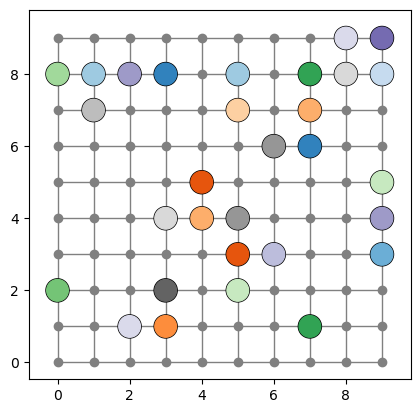

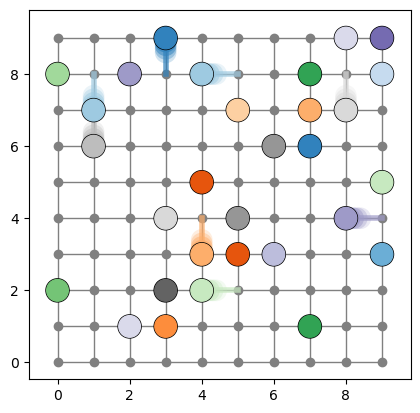

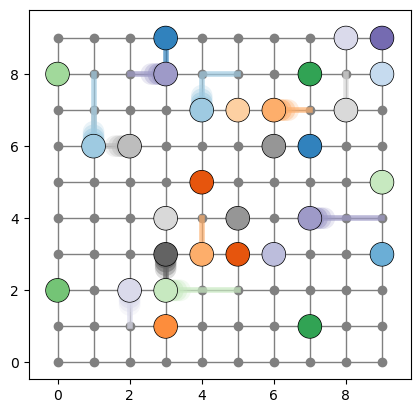

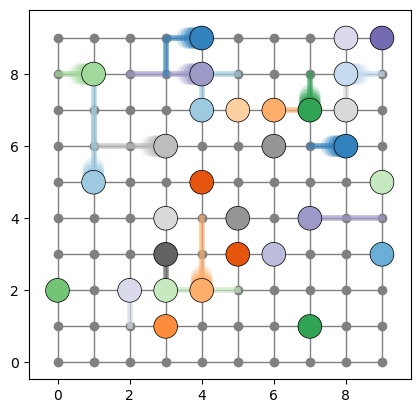

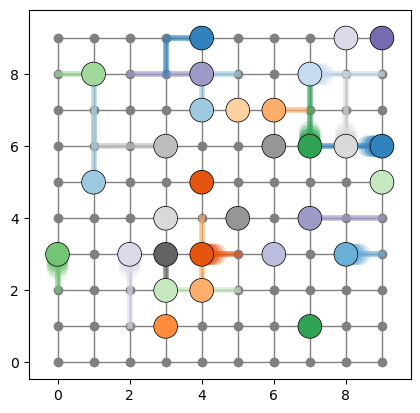

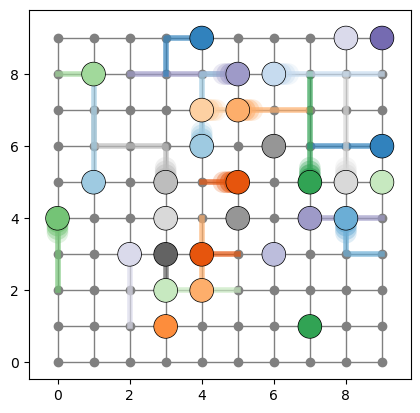

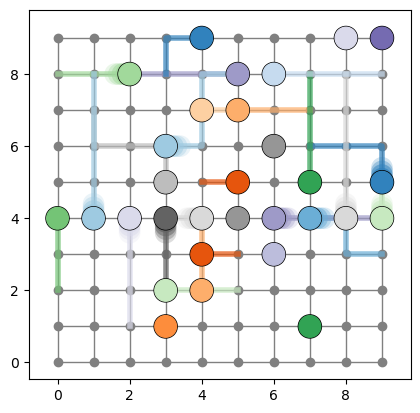

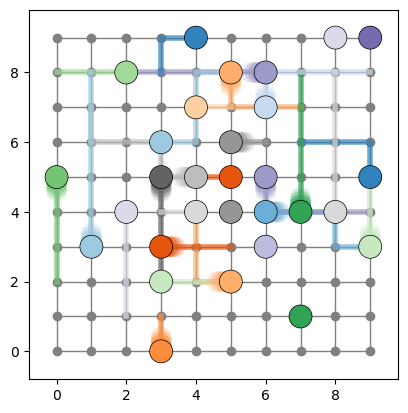

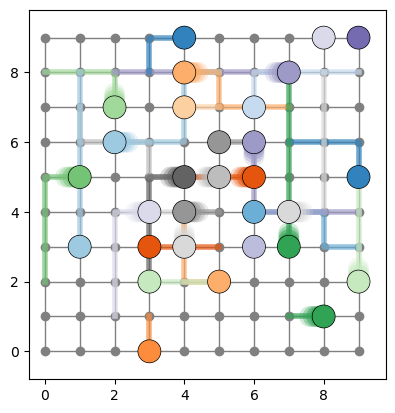

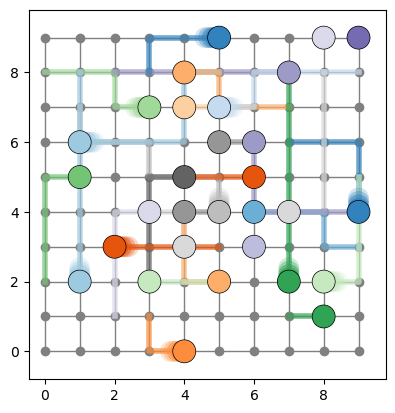

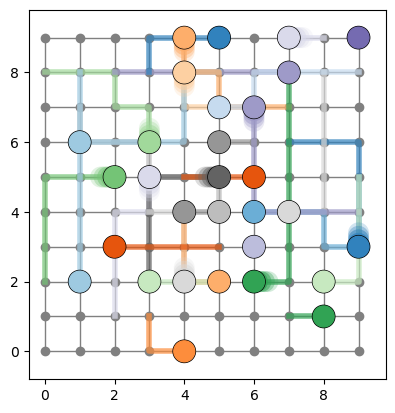

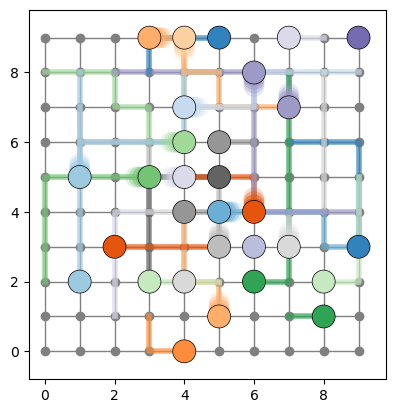

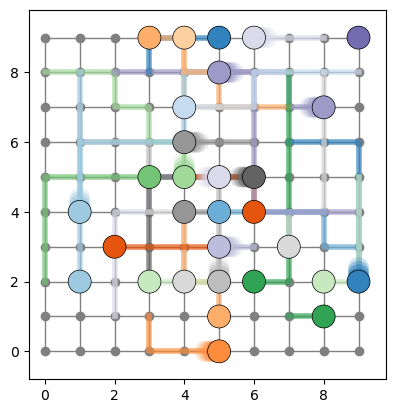

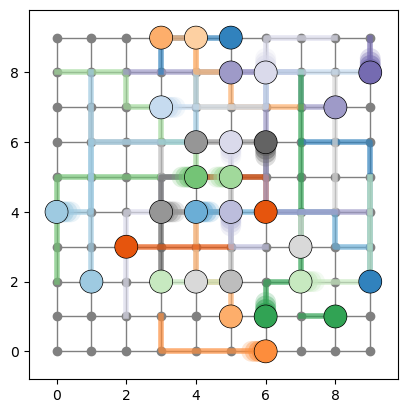

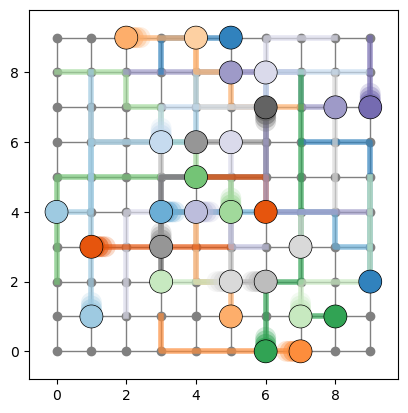

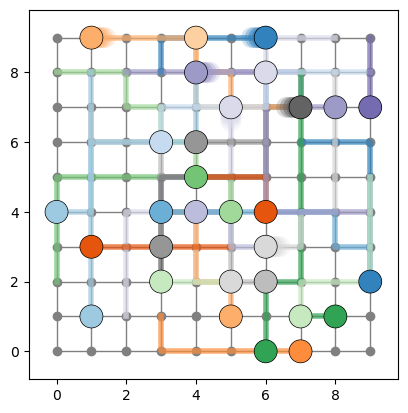

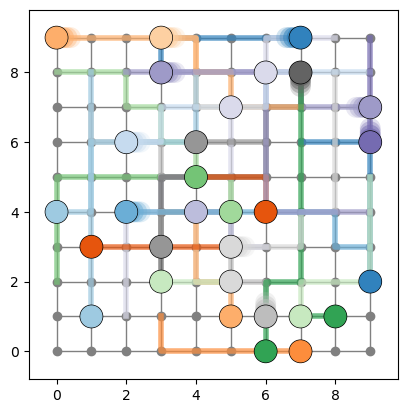

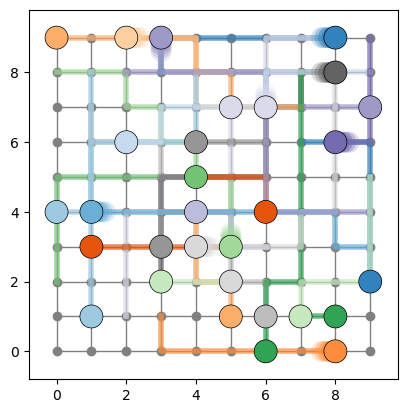

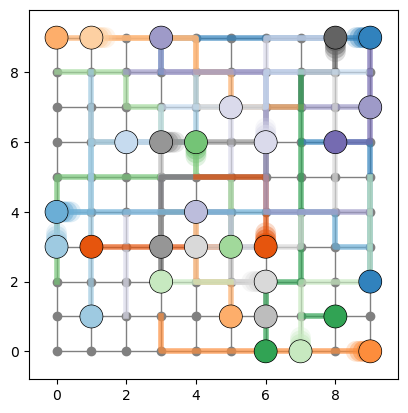

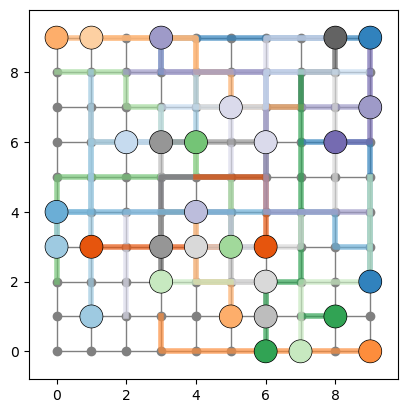

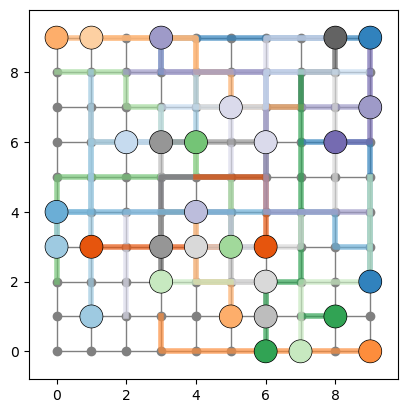

In [5]:
from visualization import show_solution
show_solution(larger_graph, solution)

In [11]:
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import networkx as nx
import typing
from matplotlib import cm
from IPython import display

class Robot:
    def __init__(self, ax, path, color):
        self._path = path
        self._path_line, = ax.plot([p[0] for p in self._path[:1]], [p[1] for p in self._path[:1]],
                                  zorder=2, color=color, alpha=0.7, lw=4)
        self._outer_circle = plt.Circle(self._path[0], 0.32, color="black", zorder=4)
        self._inner_circle = plt.Circle(self._path[0], 0.3, color=color, zorder=5)
        self._shadows = [plt.Circle(self._path[0], 0.3, color=color, zorder=3, alpha=t ** 3, linewidth=0) for t in [0.6, 0.7, 0.8, 0.9]]
        ax.add_patch(self._outer_circle)
        ax.add_patch(self._inner_circle)
        for c in self._shadows:
            ax.add_patch(c)

    def move(self, i):
        self._path_line.set_data([p[0] for p in self._path[:i+1]], [p[1] for p in self._path[:i+1]])
        self._outer_circle.center = self._path[i]
        self._inner_circle.center = self._path[i]
        prev_pos = self._path[i-1] if i>0 else self._path[0]
        for i_, t in enumerate([0.6, 0.7, 0.8, 0.9]):
            x = t * self._path[i][0] + (1 - t) * prev_pos[0]
            y = t * self._path[i][1] + (1 - t) * prev_pos[1]
            self._shadows[i_].center = (x,y)



def plot_graph(ax: plt.Axes, graph: nx.Graph):
    ax.plot([p[0] for p in graph.nodes], [p[1] for p in graph.nodes], "o", c="grey",
            zorder=1)
    for e in graph.edges:
        ax.plot([e[0][0], e[1][0]], [e[0][1], e[1][1]], c="grey", zorder=1, lw=1)

class AnimationFunction:
    def __init__(self, graph: nx.Graph, solution: typing.Dict):
        self.solution = solution
        self.fig = plt.figure()
        self.ax = plt.gca()
        self.ax.set_aspect('equal', adjustable='box', anchor='C')
        plot_graph(self.ax, graph)
        colors = cm.get_cmap("tab20c", len(solution))
        self.robots = [Robot(self.ax, path, colors(i)) for i, path in solution.items()]

    def __len__(self):
        return len(self.solution[0])

    def __call__(self, i):
        for r, path in self.solution.items():
            self.robots[r].move(i)
        #return [robot._inner_circle for robot in self.robots]

anim_func = AnimationFunction(larger_graph, solution)
anim = FuncAnimation(anim_func.fig, func=anim_func,
                     frames = len(anim_func),
                     interval = 400,
                     blit = False)


anim.save('animation.gif', writer='imagemagick', fps=2)


video = anim.to_jshtml()
html = display.HTML(video)
display.display(html)
plt.close()
#anim_func(10)


In [7]:
def remove_duplicates(l):
    l_ = []
    for e in l:
        if not l_ or e!=l_[-1]:
            l_.append(e)
    return l_
paths = list(remove_duplicates(l) for l in solution.values())
from path_conflict_minimizer import PcmModel
PcmModel(paths, 20).optimize(60)


Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 12173 rows, 8801 columns and 50557 nonzeros
Model fingerprint: 0x3e60579a
Variable types: 314 continuous, 8487 integer (8487 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2848 rows and 1227 columns
Presolve time: 0.20s
Presolved: 9325 rows, 7574 columns, 43003 nonzeros
Variable types: 0 continuous, 7574 integer (7362 binary)
Found heuristic solution: objective 39.0000000
Found heuristic solution: objective 34.0000000

Root relaxation: objective 0.000000e+00, 3016 iterations, 0.07 seconds (0.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work


{'movements': [(0, (((0, 2), 0), ((0, 3), 1))),
  (0, (((0, 3), 1), ((0, 4), 2))),
  (0, (((0, 4), 2), ((0, 4), 3))),
  (0, (((0, 4), 3), ((0, 4), 4))),
  (0, (((0, 4), 4), ((0, 4), 5))),
  (0, (((0, 4), 5), ((0, 4), 6))),
  (0, (((0, 4), 6), ((0, 4), 7))),
  (0, (((0, 4), 7), ((0, 5), 8))),
  (0, (((0, 5), 8), ((0, 5), 9))),
  (0, (((0, 5), 9), ((0, 5), 10))),
  (0, (((0, 5), 10), ((0, 5), 11))),
  (0, (((0, 5), 11), ((0, 5), 12))),
  (0, (((0, 5), 12), ((0, 5), 13))),
  (0, (((0, 5), 13), ((0, 5), 14))),
  (0, (((0, 5), 14), ((0, 5), 15))),
  (0, (((0, 5), 15), ((0, 5), 16))),
  (0, (((0, 5), 16), ((0, 5), 17))),
  (0, (((0, 5), 17), ((0, 5), 18))),
  (0, (((0, 5), 18), ((0, 5), 19))),
  (0, (((0, 5), 19), ((0, 5), 20))),
  (0, (((0, 5), 20), ((0, 5), 21))),
  (0, (((0, 5), 21), ((1, 5), 22))),
  (0, (((1, 5), 22), ((2, 5), 23))),
  (0, (((2, 5), 23), ((2, 5), 24))),
  (0, (((2, 5), 24), ((3, 5), 25))),
  (0, (((3, 5), 25), ((4, 5), 26))),
  (0, (((4, 5), 26), ((4, 6), 27))),
  (1, (